In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1)**Loading MNIST dataset:**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes with MNIST mean & std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


# **2) Visualizing some images:**

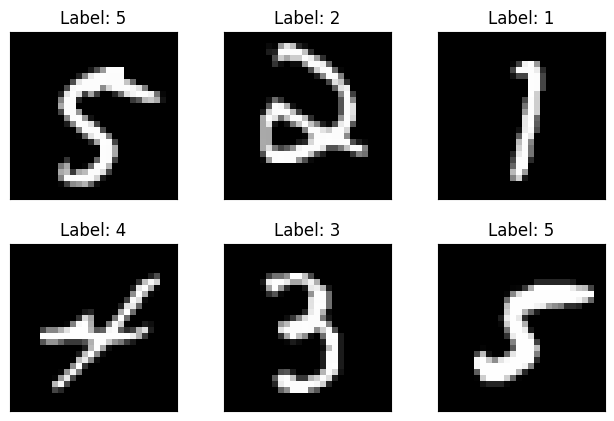

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# **3) Defining CNN Architecture:**

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # [batch, 32, 26, 26]
        x = F.relu(self.conv2(x))  # [batch, 64, 24, 24]
        x = F.max_pool2d(x, 2)     # [batch, 64, 12, 12]
        x = self.dropout1(x)
        x = torch.flatten(x, 1)    # Flattens all but batch
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# **4) Instantiating Model, Defining Optimizer and loss:**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

#**5) Training Loop:**

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.6f}")

#**6) Testing Loop:**

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

#**7) Run Training and Testing:**

In [8]:
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000]  Loss: 2.305999
Train Epoch: 1 [6400/60000]  Loss: 0.206567
Train Epoch: 1 [12800/60000]  Loss: 0.385475
Train Epoch: 1 [19200/60000]  Loss: 0.070912
Train Epoch: 1 [25600/60000]  Loss: 0.046511
Train Epoch: 1 [32000/60000]  Loss: 0.266036
Train Epoch: 1 [38400/60000]  Loss: 0.256700
Train Epoch: 1 [44800/60000]  Loss: 0.069115
Train Epoch: 1 [51200/60000]  Loss: 0.236592
Train Epoch: 1 [57600/60000]  Loss: 0.064756

Test set: Average loss: 0.0500, Accuracy: 9836/10000 (98.36%)

Train Epoch: 2 [0/60000]  Loss: 0.087906
Train Epoch: 2 [6400/60000]  Loss: 0.101270
Train Epoch: 2 [12800/60000]  Loss: 0.042919
Train Epoch: 2 [19200/60000]  Loss: 0.119204
Train Epoch: 2 [25600/60000]  Loss: 0.029156
Train Epoch: 2 [32000/60000]  Loss: 0.080164
Train Epoch: 2 [38400/60000]  Loss: 0.040963
Train Epoch: 2 [44800/60000]  Loss: 0.174815
Train Epoch: 2 [51200/60000]  Loss: 0.027279
Train Epoch: 2 [57600/60000]  Loss: 0.013718

Test set: Average loss: 0.0396, Accuracy: 987

In [9]:
# 8) Saving the Trained Model:**

model_path = "mnist_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to mnist_cnn.pth


In [10]:
# 9) Loading the saved model

loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("Model loaded successfully.")

Model loaded successfully.


# **10) Making prediction with Loaded Model:**

In [11]:
def predict(model, device, data_loader, num_samples=6):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    preds = output.argmax(dim=1)

    # Visualizing predictions
    fig = plt.figure()
    for i in range(num_samples):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(images[i][0].cpu(), cmap='gray', interpolation='none')
        plt.title(f"Pred: {preds[i].item()}, Label: {labels[i].item()}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

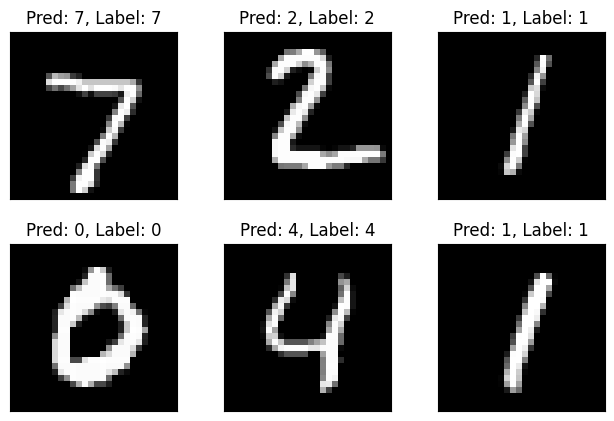

In [12]:
# Running predictions:

predict(loaded_model,device,test_loader)